<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/OC_SMF_Acciones%20Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manejo de Acciones

**Oliver Cuate**

*28 de febrero de 2025*

---

En este cuaderno le mostraré cómo usar [Pymoo](https://pymoo.org/) para resolver el problema clásico de portafolios (2 acciones).

## Obtener precios de acciones

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

print(inicio, hoy)

#tickers = ["^MXX", "BIMBOA.MX"]     # IPC MEXICO, BIMBO
tickers = ["KOF", "DELL"]     # CEMEX, BIMBO

# inicio.strftime('%Y-%m-%d') # por si hay error
#datos = yf.download(ticker, start=inicio, end=hoy).copy() # todos los datos

datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy() # todos los datos

[*********************100%***********************]  2 of 2 completed

2020-03-01 16:09:59.422161 2025-02-28 16:09:59.422161


Vemos los datos

In [ ]:
datos

Ticker,DELL,KOF
Date,,
2020-03-02,19.974045,45.343891
2020-03-03,19.686617,44.772968
2020-03-04,20.440533,45.408215
2020-03-05,19.248405,44.218132
2020-03-06,18.668829,43.405975
...,...,...
2025-02-24,114.139999,88.339996
2025-02-25,110.650002,87.730003
2025-02-26,115.650002,86.589996


## Calculamos los rendimientos

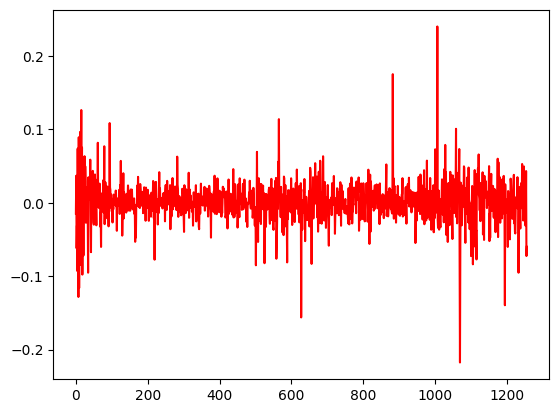

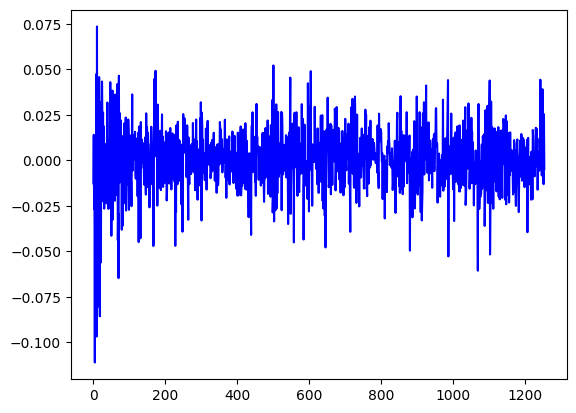

In [ ]:
rend = (datos.values[1:]-datos.values[0:-1])/datos.values[1:]

plt.plot(range(rend.shape[0]),rend[:,0],'r')
plt.show()

plt.plot(range(rend.shape[0]),rend[:,1],'b')
plt.show()

In [ ]:
r = rend.mean(axis=0)
r

array([0.00091096, 0.00038424])

In [ ]:
Cov = np.cov(rend, rowvar=False)
Cov

array([[0.00076513, 0.00012935],
       [0.00012935, 0.0002965 ]])

## Uso de Pymoo

Primero, hay que instalar Pymoo

In [ ]:
!pip install -U pymoo

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      7 |  0.000000E+00 |  0.2551687336 |             - |             -
     2 |      100 |     15 |  0.000000E+00 |  0.0366190309 |  0.0302989290 |         ideal
     3 |      150 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0869738874 |         ideal
     4 |      200 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0257014254 |         ideal
     5 |      250 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0566374434 |         nadir
     6 |      300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0063102449 |             f
     7 |      350 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0053171764 |             f
     8 |      400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0018364833 |             f
     9 |      450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0037092007 |             f
    10 |      500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0032707278 |             f

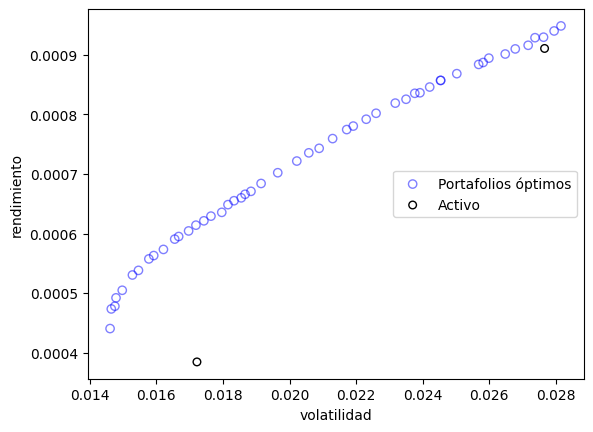

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class Portafolio(Problem):   # nombre que le queremos dar (Nombre de lo que es)
  def __init__(self, mu, cov):
    self.mu = mu
    self.cov = cov
    super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)
                    # tenemos 2 activos
                    #          2 objetivos, minimizatr y maximizar
                    #                  restriccion es que la suma de pesos sea igual a 1
                    #                                   los pesos estan entre 0 y 1

  def _evaluate(self, x, out, *args, **kwargs):
    rendimiento = x @ self.mu
    riesgo = np.zeros(x.shape[0])
    for (i,w) in enumerate(x):
      riesgo[i] = np.sqrt(w @ self.cov @ w.T)

    out["F"] = [riesgo, -rendimiento]
    out["G"] = np.abs( np.sum(x, axis=1) - 1.0 ) - 0.1

problem = Portafolio(r,Cov)

algorithm = NSGA2(pop_size=50)   # poblacion de 50

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=True)


X, F = res.opt.get("X", "F")
F = F * [1, -1]

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.scatter(Cov.diagonal() ** 0.5, r, facecolor="none", edgecolors="black", s=30, label="Activo")
#plt.legend(loc='best')
plt.legend(loc=7)
plt.xlabel("volatilidad")
plt.ylabel("rendimiento")
plt.show()

In [ ]:
np.sum( res.X, axis=1 )

array([0.90290133, 1.09998398, 1.09094743, 1.09829229, 1.09866405,
       0.90590822, 0.92295027, 1.08401407, 1.08847033, 1.0274732 ,
       1.03234712, 1.086691  , 1.07695343, 0.90034776, 0.90016847,
       0.90834434, 1.06427771, 0.90098771, 1.07289704, 1.09368999,
       1.09694525, 0.90337438, 1.08586949, 1.02123733, 1.08048308,
       1.04730714, 0.90061499, 0.9261369 , 0.97432911, 1.08322802,
       0.90635573, 1.03332635, 1.09939299, 1.07436238, 1.09942381,
       1.07691647, 0.90792968, 1.09740297, 0.98153871, 0.96569185,
       1.07779662, 0.95781855, 1.04422316, 0.90648669, 1.09626083,
       1.0996443 , 1.03212915, 1.08307011, 1.01965049, 0.93908696])

[Posición de la etiqueta](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)